In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, re

import modules.MainFunctions as MF

from modules.ShapeGenerator import *

from mpl_toolkits.mplot3d import Axes3D
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

N=50
Lmax= 18

%load_ext autoreload
%autoreload 2
%matplotlib notebook

### First we need to compute RY

In [2]:
N=50
Lmax=18
savePath='data/precomputedRY/'

In [ ]:
#MF.compute_RY(M=2*N, Lmax=Lmax, saveRY=True, savePath=savePath, returnRY=False, barycentre=None, verbose=True)

In [3]:
big_RY=MF.find_RY(N,Lmax,RY_PATH=savePath)

Loading data/precomputedRY/RY_M_100_Lmax_18_.npy


### Generate shapes with the radius function 

<IPython.core.display.Javascript object>


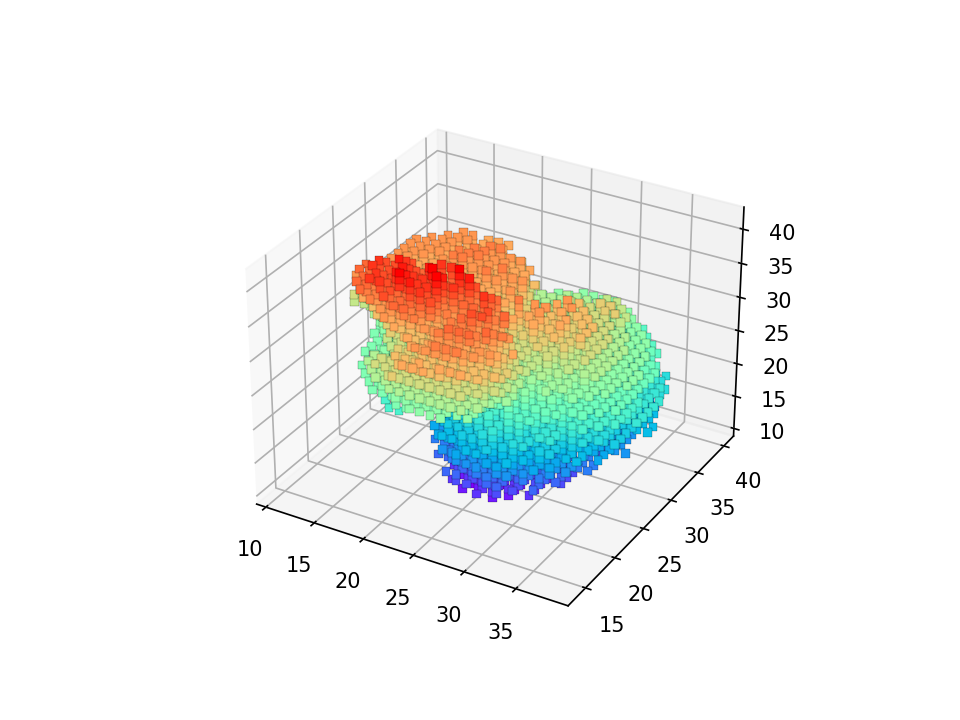

In [4]:
base=3 #this is the base sphere radius, ie. the minimal radius of the shape
variation=15 #this is the amplitude of the variation added, the maximum radius of the shape will be base+variation
force=1 #this is the amplitude of the polynom coefficients used in the pre_radius function
deg=2 #this is the degree of the polynom 

pA,pB,pC,pD = [define_coefs(force,deg) for i in range (4)] #define a new radius function with random coefficients

shape,vertices=construct_shape(N,base,variation, pA,pB,pC,pD)
show_shape(vertices)


Decompose this generated shape 

361


<IPython.core.display.Javascript object>


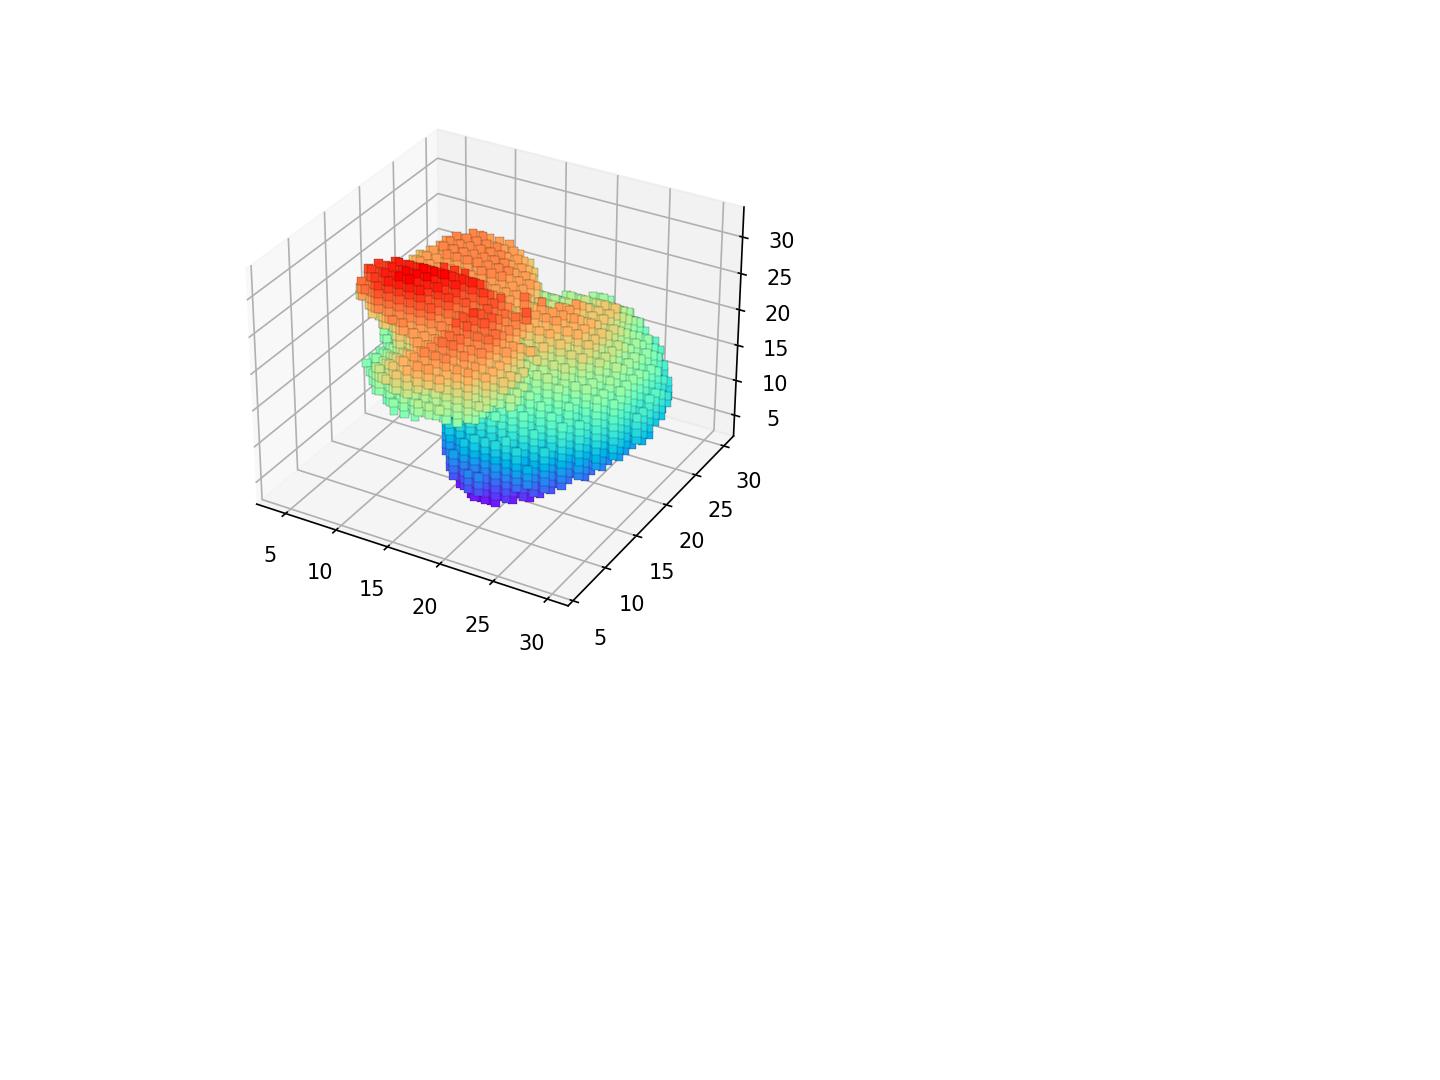

In [5]:
#save the shape
strn="./tmp/tmp_file.txt"
np.savetxt(strn, vertices, fmt="%s", delimiter=", ")

form,N2,b=MF.get_object_param(strn)
        
cr = MF.decompose(strn,Lmax,big_RY=big_RY,verbose=False)
print(len(cr))
np.save("./tmp/tmp_file",cr)
RY = MF.extract_RY(big_RY,N2,b)
re_shape=MF.recompose("./tmp/tmp_file.npy",N2,b,RY=RY)[0]
re_vertices=np.argwhere(re_shape==1)
error=0.01*MF.error(form,re_shape)
show_shape(re_vertices)

<IPython.core.display.Javascript object>


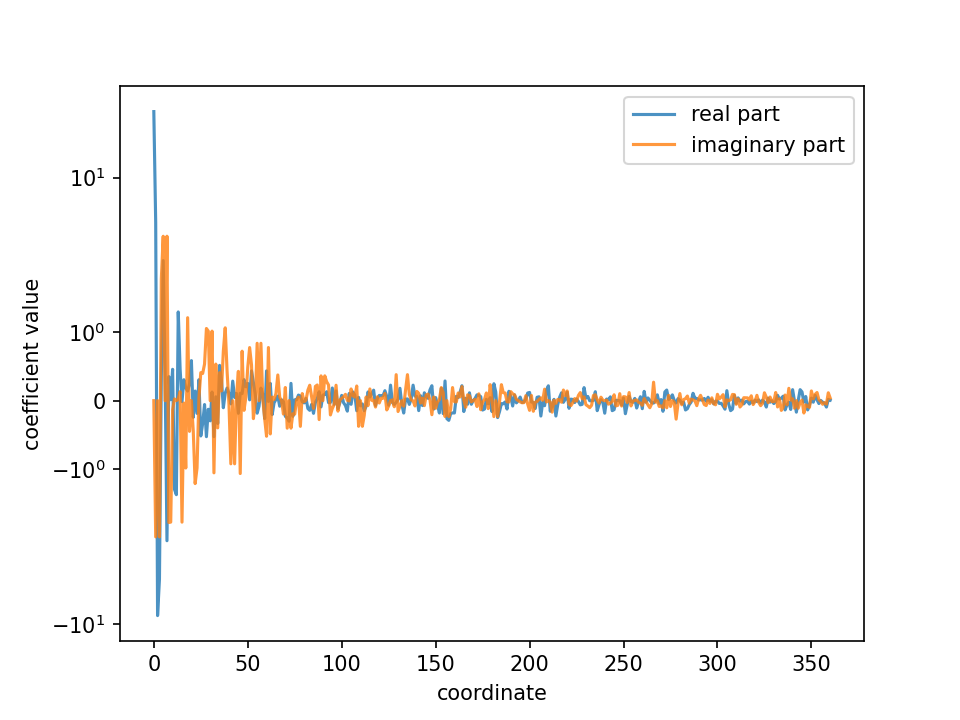

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=1)
Yr=np.real(cr)
Yi=np.imag(cr)
X=np.arange(len(Yr))
plt.plot(X,Yr,alpha=0.8,label='real part')
plt.plot(X,Yi,alpha=0.8,label='imaginary part')
plt.xlabel('coordinate')
plt.ylabel('coefficient value')
plt.legend()
plt.yscale('symlog')
plt.show()

### Generate unions of cuboids 

<IPython.core.display.Javascript object>


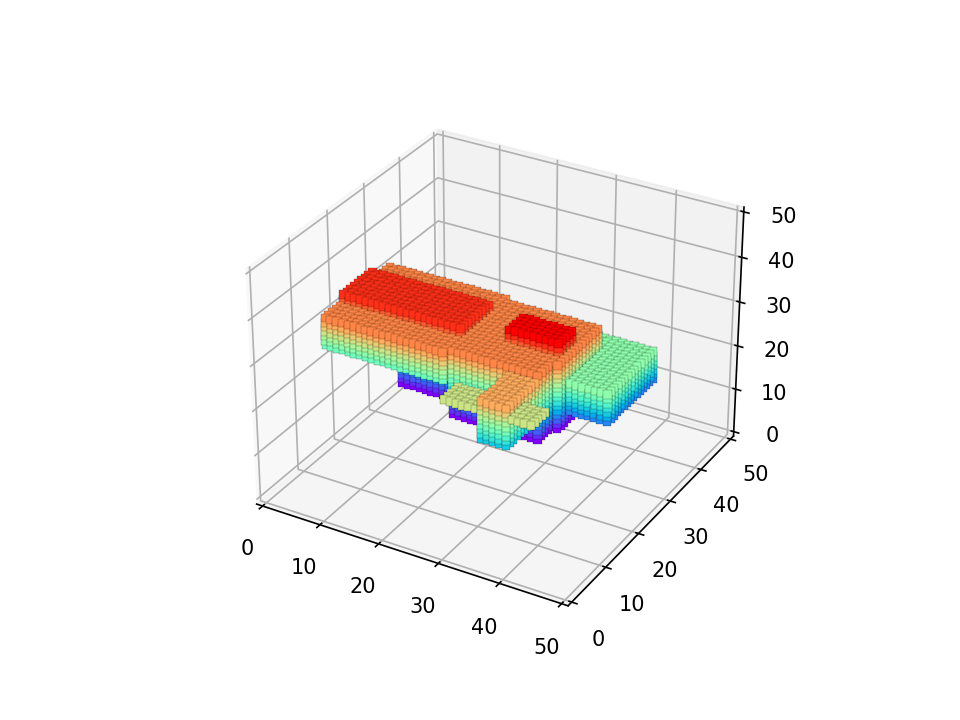

In [7]:
shape=generate_random_cuboid(N,10,connexe=True)
vertices  = np.argwhere(shape == 1)
show_shape(vertices,50)

### Now we generate many shapes

In [8]:
def save_txt(array,path,file_name,number):
    strn=path+file_name+"_"+str(number)+".txt"
    np.savetxt(strn, array, fmt="%s", delimiter=", ")
    return strn

def generate_shapes(shape_type,N,n,path,error_threshold,Lmax,big_RY):
    path2 = path[:-1]
    isExist = os.path.exists(path2)
    if not isExist:
        os.mkdir(path2)
        
    if os.path.isfile(path+'ravel_spectrums.npy'):
        print ("Laoding "+path+"ravel_spectrums.npy")
        RAVEL_SPECTRUMS=np.load(path+'ravel_spectrums.npy')
    else:
        RAVEL_SPECTRUMS=np.array([])
    print ("Starting generating shapes")
    print ("Generating "+str(n)+" shapes of size "+str(N)+ " and type "+shape_type)
    print ("Decomposing with Lmax="+str(Lmax)+ " and error threshold="+str(error_threshold))
    print ("Using path : "+path)
    print("-----------------------")
    i=0
    j=0
    all_errors=[]
    accepted_errors=[]
    
    while i < n:
        j+=1
        #produce a shape
        if shape_type=='radius':
            base=3 #this is the base sphere radius, ie. the minimal radius of the shape
            variation=15 #this is the amplitude of the variation added, the maximum radius of the shape will be base+variation
            force=1 #this is the amplitude of the polynom coefficients used in the pre_radius function
            deg=2 #this is the degree of the polynom 
            pA,pB,pC,pD = [define_coefs(force,deg) for i in range (4)] #define a new radius function with random coefficients
            shape,vertices=construct_shape(N,base,variation, pA,pB,pC,pD)
        elif shape_type=='cuboids' :
            n_cubes=5
            shape=generate_random_cuboid(N,n_cubes,connexe=True)
            vertices  = np.argwhere(shape == 1)
        else :
            print("no such shape type")
            return
        
        #save the shape
        strn="./tmp/tmp_file.txt"
        np.savetxt(strn, vertices, fmt="%s", delimiter=", ")
        
        form,N2,b=MF.get_object_param(strn)
        
        #decompose the shape
        cr = MF.decompose(strn,Lmax,big_RY=big_RY,verbose=False)
        np.save("./tmp/tmp_file",cr)
        RY = MF.extract_RY(big_RY,N2,b)
        re_shape=MF.recompose("./tmp/tmp_file.npy",N2,b,RY=RY)[0]
        error=0.01*MF.error(form,re_shape)
        all_errors.append(error)
        
        #discard if the recomposition touches the side
        ind=np.zeros(N2)
        ind[:2]=1
        ind[-2:]=1
        II=np.tile(ind,(N2,N2,1)).transpose(2,1,0)
        JJ=np.tile(ind,(N2,N2,1)).transpose(0,2,1)
        KK=np.tile(ind,(N2,N2,1))
        SIDES=(II+JJ+KK)>=1
        touches_side=np.sum(re_shape*SIDES)>=1

        if (error>error_threshold) or touches_side:
            i=i-1
            print("\r"+str(j)+" Warning : error is "+str(int(100*error)) +"% for shape number "+str(i)+"           ", end="\r")
        else:
            #save the complex spectrum
            accepted_errors.append(error)
            print("\r"+str(j)+" Decomposition error is "+str(int(100*error)) +"% for shape number "+str(i)+"           ", end="\r")
            a=np.real(cr)
            b=np.imag(cr)
            c = np.ravel(np.column_stack((a,b)))
            if len(RAVEL_SPECTRUMS)==0:
                RAVEL_SPECTRUMS = np.array([c])
            else:
                RAVEL_SPECTRUMS = np.vstack([RAVEL_SPECTRUMS,c])
        i+=1
    print("")
    print("Saving ravel_spectrums at "+path+'ravel_spectrums.npy')
    np.save(path+'ravel_spectrums.npy',RAVEL_SPECTRUMS)
    np.savetxt(path+"info.txt", np.shape(RAVEL_SPECTRUMS), fmt="%s", delimiter=", ")
    return all_errors,accepted_errors
  


### Then we generate shapes

In [9]:
number_of_images= 4000
error_threshold = 10

In [24]:
all_errors,accepted_errors=generate_shapes('cuboids',N,number_of_images,'data/3DGeneratedCuboids/',error_threshold,Lmax,big_RY)

Laoding data/3DGeneratedCuboids/ravel_spectrums.npy
Starting generating shapes
Generating 4000 shapes of size 50 and type cuboids
Decomposing with Lmax=18 and error threshold=10
Using path : data/3DGeneratedCuboids/
-----------------------
14869 Decomposition error is 5% for shape number 3999            
Saving ravel_spectrums at data/3DGeneratedCuboids/ravel_spectrums.npy


<IPython.core.display.Javascript object>


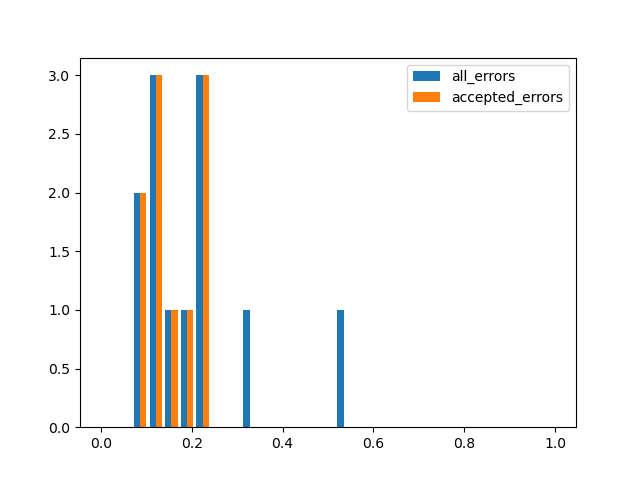

C:\Users\Simon\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [26]:

x = all_errors
y = accepted_errors

bins = np.linspace(0, 1, 30)

plt.hist([x,y], bins, alpha=1, label=['all_errors','accepted_errors'])
plt.legend(loc='upper right')
plt.show()

### We get the decomposition of already built shapes

In [10]:
def decompose_shapes(path,error_threshold,Lmax,big_RY):
    print ("Starting decomposing shapes")
    print ("Decomposing with Lmax="+str(Lmax)+ " and error threshold="+str(error_threshold))
    print ("Using shape path : "+path)
    path2 = path[:-1]+"_spectrum/"
    print ("Saving spectrums at : " + path2 )
    print("-----------------------")
    
    isExist = os.path.exists(path2)

    if not isExist:
        os.mkdir(path2)
    
    files = os.listdir('./'+path)
    k=len(files)
    i=0
    for e in files:
        i+=1
        strn=path+e

        #get the shape info
        form,N2,b=MF.get_object_param(strn)
        
        #decompose the shape
        cr = MF.decompose(strn,Lmax,big_RY=big_RY,verbose=False)
        np.save(path+"tmp",cr)
        RY = MF.extract_RY(big_RY,N2,b)
        re_shape=MF.recompose(path+"tmp.npy",N2,b,RY=RY)[0]
        error=0.01*MF.error(form,re_shape)
        
        
        #discard if the error is too big       

        if error>error_threshold:
            print("\r"+str(i)+"/"+str(k)+"  - Doing file "+e+" | error is : "+str(int(100*error)) +"% - warning                           ", end="\r")
        else:
            print("\r"+str(i)+"/"+str(k)+"  - Doing file "+e+" | error is : "+str(int(100*error)) +"%                              ", end="\r")
            #save the complex spectrum
            strn2=save_txt(cr,path2,"spectrum",e[:-4])
            a=np.real(cr)
            b=np.imag(cr)
            c = np.ravel(np.column_stack((a,b)))
            strn3=save_txt(c,path2,"ravel_spectrum",e[:-4])
            
            #save the error
            strn=save_txt(np.array([error]),path2,"error",e[:-4])
            
            
    print(" ")
    print(" ")

### Convert list of txt spectrum to csv file

In [218]:
def spectrums_to_npy(path,npy_name):
    print("-----")
    print("Converting list of spectrum to a single npy file")
    files = os.listdir('./'+path)
    k=len(files)
    i=0
    NPY=[]
    for e in files:
        if ('txt' in e) and ('ravel' in e): 
            i+=1
            strn=path+e
            print("\r"+str(i)+"/"+str(k)+"  - Doing file "+strn, end="\r")
            file = open(path+e,"r").read()
            file = re.split("\n|, | ",file)
            if file[-1]=='':
                file=file[:-1]
            data = np.asarray(file,dtype=float)
            np.save(path+e[:-4]+".npy", data)
            if len(NPY)==0:
                NPY=np.array([data])
            else:
                NPY=np.vstack([NPY,np.array([data])])
    np.save(path+npy_name+".npy", NPY)
    print('')
    print("Saving at "+ path+npy_name+".npy")
    return 
    

In [219]:
decompose_shapes('data/3DSyntheticForm/txt/',0.2,18,big_RY)
spectrums_to_npy('data/3DSyntheticForm/txt_spectrum/','0_spectrums')

Starting decomposing shapes
Decomposing with Lmax=18 and error threshold=0.2
Using shape path : data/3DSyntheticForm/txt/
Saving spectrums at : data/3DSyntheticForm/txt_spectrum/
-----------------------
-----35  - Doing file truncated_tetrahedron.txt | error is : 1%                                                    
Converting list of spectrum to a single npy file
134/537  - Doing file data/3DSyntheticForm/txt_spectrum/ravel_spectrum_truncated_tetrahedron.txton.txtn.txt.txtron.txt
Saving at data/3DSyntheticForm/txt_spectrum/0_spectrums.npy


In [221]:
decompose_shapes('data/3DSyntheticForm/txt_angular/',0.2,18,big_RY)
spectrums_to_npy('data/3DSyntheticForm/txt_angular_spectrum/','0_angular_spectrums')

Starting decomposing shapes
Decomposing with Lmax=18 and error threshold=0.2
Using shape path : data/3DSyntheticForm/txt_angular/
Saving spectrums at : data/3DSyntheticForm/txt_angular_spectrum/
-----------------------
 25/125  - Doing file truncated_tetrahedron_angular.txt | error is : 2%                                                    
 
-----
Converting list of spectrum to a single npy file
117/351  - Doing file data/3DSyntheticForm/txt_angular_spectrum/ravel_spectrum_truncated_tetrahedron_angular.txtar.txtr.txttxtular.txt
Saving at data/3DSyntheticForm/txt_angular_spectrum/0_angular_spectrums.npy
